In [1]:
%load_ext autoreload
%autoreload 2

In [13]:
import os
import sys
import numpy as np
import torch

import matplotlib.pyplot as plt
%matplotlib inline

from pcdet.models import build_network, load_data_to_gpu
from pcdet.models.backbones_2d.map_to_rv.range_projection import SphereProjection, BasicRangeProjection
from pcdet.utils.common_utils import create_logger
from pathlib import Path
from pcdet.config import cfg, cfg_from_yaml_file

# H-FOV & V-FOV

## KITTI

In [2]:
from pcdet.datasets.kitti.kitti_dataset import KittiDataset

In [3]:
data_path = Path('../data/kitti')
cfg_file = '../tools/cfgs/dataset_configs/kitti_dataset_noAug.yaml'

class_names = ['Car', 'Pedestrian', 'Cyclist']
cfg_from_yaml_file(cfg_file, cfg)

logger = create_logger()
# use val set, no aug for statistic!
kitti_dataset = KittiDataset(cfg, class_names=class_names, root_path=data_path, logger=logger, training=False)


2021-07-30 15:00:42,002   INFO  Loading KITTI dataset
2021-07-30 15:00:42,141   INFO  Total samples for KITTI dataset: 3769


In [4]:
minmax = [] # rMin, thetaMin, phiMin, rMax, thetaMax, phiMax
for i, data_dict in enumerate(kitti_dataset):
    sys.stdout.write(f'\rprocessing {i}/{len(kitti_dataset)}')
    points = data_dict['points']
    xyz = torch.from_numpy(points[:, 0:3])
    
    rThetaPhi = SphereProjection.xyz_to_rThetaPhi(xyz).numpy()
    rtp_min = rThetaPhi.min(axis=0)
    rtp_max = rThetaPhi.max(axis=0)
    minmax.append(list(rtp_min) +  list(rtp_max))
    
#     break
    

processing 195/3769

KeyboardInterrupt: 

In [ ]:
minmax = np.array(minmax)
minmax[:, [1,2,4,5]]*=57.3
minmax

In [ ]:
titles = ['rMin', 'thetaMin', 'phiMin', 'rMax', 'thetaMax', 'phiMax']

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

for i, row in enumerate(ax):
    for j, col in enumerate(row):
        col.scatter(range(minmax.shape[0]), minmax[:, i*3+j])
        col.title.set_text(titles[i*3+j])
        

#### 分布

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

for i, row in enumerate(ax):
    for j, col in enumerate(row):
        col.hist(minmax[:, i*3+j], bins=100)
        col.title.set_text(titles[i*3+j])

> HFOV：(-41, 41); VFOV: (-5, 15)

# RangeProjection feature mean & std

In [7]:
from easydict import EasyDict

## KITTI

In [12]:
from pcdet.datasets.kitti.kitti_dataset import KittiDataset

In [5]:
data_path = Path('../data/kitti')
cfg_file = '../tools/cfgs/dataset_configs/kitti_dataset_noAug.yaml'

class_names = ['Car', 'Pedestrian', 'Cyclist']
cfg_from_yaml_file(cfg_file, cfg)

logger = create_logger()
# use val set, no aug for statistic!
kitti_dataset = KittiDataset(cfg, class_names=class_names, root_path=data_path, logger=logger, training=True)


2021-07-30 15:42:20,004   INFO  Loading KITTI dataset
2021-07-30 15:42:20,130   INFO  Total samples for KITTI dataset: 3712


In [62]:
cfg = EasyDict()

### KITTI
cfg.USE_RINGID = False
cfg.RINGID_IDX = -1
cfg.USE_XYZ = True
cfg.H_FOV = [-41, 41]
cfg.WIDTH = 512
cfg.V_FOV = [-5, 15]
cfg.HEIGHT = 64
cfg.H_UPSAMPLE_RATIO = 2

cfg.TRAIN_CFG = EasyDict()
cfg.TRAIN_CFG.FILTER_GT_BOXES = True
cfg.TRAIN_CFG.USE_OBSERVATION_ANGLE = True

rp = BasicRangeProjection(cfg, input_channels=4)


In [57]:
# get mean
fea_sum = 0
points_cnt = 0
for i, data_dict in enumerate(kitti_dataset):
    sys.stdout.write(f'\rprocessing {i}/{len(kitti_dataset)}')
    data_dict = kitti_dataset.collate_batch([data_dict])
    load_data_to_gpu(data_dict)
    data_dict = rp(data_dict)
    
    rv_image = data_dict['spatial_features'][0].permute(1, 2, 0).cpu().numpy()[...,:7] #HWC, xyz rThetaPhi intensity
    mask = (rv_image.sum(-1) != 0)
    
    valid_points = rv_image[mask]
    fea_sum += valid_points.sum(0)
    points_cnt += valid_points.shape[0]
#     break
    
mean = fea_sum / points_cnt
    
mean

processing 3711/3712

array([ 1.63557622e+01,  2.06396953e-01, -1.05997715e+00,  1.77747792e+01,
        1.13989087e-02,  9.62784147e-02,  2.45270869e-01])

In [60]:
np.set_printoptions(precision=6, suppress=True)
mean


array([16.355762,  0.206397, -1.059977, 17.774779,  0.011399,  0.096278,
        0.245271])

In [64]:
# get std
fea_sum = 0
points_cnt = 0
for i, data_dict in enumerate(kitti_dataset):
    sys.stdout.write(f'\rprocessing {i}/{len(kitti_dataset)}')
    data_dict = kitti_dataset.collate_batch([data_dict])
    load_data_to_gpu(data_dict)
    data_dict = rp(data_dict)
    
    rv_image = data_dict['spatial_features'][0].permute(1, 2, 0).cpu().numpy()[...,:7] #HWC, xyz rThetaPhi intensity
    mask = (rv_image.sum(-1) != 0)
    
    valid_points = rv_image[mask]
    fea_sum += ((valid_points - mean)**2).sum(0)
    points_cnt += valid_points.shape[0]
#     break
    
std = np.sqrt(fea_sum / points_cnt)

std

processing 3711/3712

array([11.729292,  6.380969,  0.77858 , 12.556925,  0.31467 ,  0.070107,
        0.15448 ])

In [65]:
new_rv_image = (rv_image - mean)/std
new_rv_image[~mask] = 0
valid_new = new_rv_image[mask]

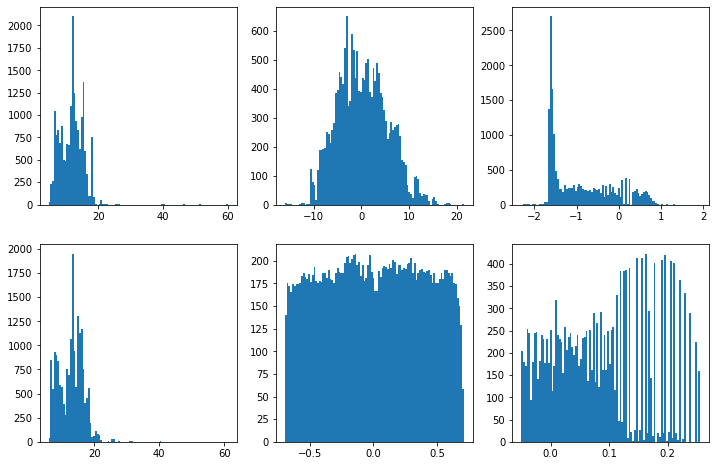

In [56]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

for i, row in enumerate(ax):
    for j, col in enumerate(row):
        col.hist(valid_points[:, i*3+j], bins=100)

In [67]:
titles = ['x', 'y', 'z', 'r', 'theta', 'phi', 'intensity']

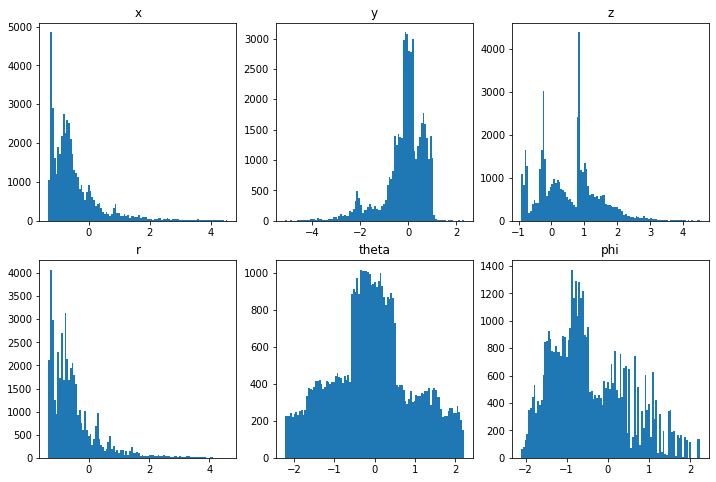

In [72]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

for i, row in enumerate(ax):
    for j, col in enumerate(row):
        col.hist(valid_new[:, i*3+j], bins=100)
        col.title.set_text(titles[i*3+j])